# Image Captioning 101

In [ ]:
!mkdir coco
!mkdir data

In [ ]:
!wget http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip -P ./coco/
!wget http://images.cocodataset.org/zips/train2014.zip -P ./coco/

--2021-05-05 03:36:20--  http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip
Resolving msvocds.blob.core.windows.net (msvocds.blob.core.windows.net)... 52.176.224.96
Connecting to msvocds.blob.core.windows.net (msvocds.blob.core.windows.net)|52.176.224.96|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19673183 (19M) [application/octet-stream Charset=UTF-8]
Saving to: ‘./coco/captions_train-val2014.zip’

captions_train-val2 100%[===================>]  18.76M  24.4MB/s    in 0.8s    

2021-05-05 03:36:21 (24.4 MB/s) - ‘./coco/captions_train-val2014.zip’ saved [19673183/19673183]

--2021-05-05 03:36:21--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.131.241
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.131.241|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘./coco/trai

In [ ]:
!unzip ./coco/captions_train-val2014.zip -d ./coco/
!unzip ./coco/train2014.zip -d ./coco/

In [ ]:
!rm ./coco/captions_train-val2014.zip
!rm ./coco/train2014.zip

In [ ]:
import os
import pickle
import numpy as np
import nltk
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
import torch.nn as nn
import matplotlib.pyplot as plt

from multiprocessing import cpu_count
from collections import Counter
from PIL import Image
from pycocotools.coco import COCO
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision.models import resnet152

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def resize_images(image_dir, output_dir, size):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images = os.listdir(image_dir)
    num_images = len(images)
    for i, image in enumerate(images):
        with open(os.path.join(image_dir, image), 'r+b') as f:
            with Image.open(f) as img:
                img = img.resize(size, Image.ANTIALIAS)
                img.save(os.path.join(output_dir, image), img.format)
        if (i + 1) % 10000 == 0:
            print ("[{}/{}] Image Resized".format(i + 1, num_images))

In [ ]:
image_dir = './coco/train2014/'
output_dir = './data/train2014/'
image_size = [256, 256]

resize_images(image_dir, output_dir, image_size)

[10000/82783] Image Resized
[20000/82783] Image Resized
[30000/82783] Image Resized
[40000/82783] Image Resized
[50000/82783] Image Resized
[60000/82783] Image Resized
[70000/82783] Image Resized
[80000/82783] Image Resized


In [ ]:
class Vocabulary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [ ]:
def build_vocab(json, threshold):
    dataset = COCO(json)
    keys = dataset.anns.keys()
    counter = Counter()

    for i, k in enumerate(keys):
        caption = str(dataset.anns[k]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

        if (i + 1) % 10000 == 0:
            print("[{}/{}] Caption Tokenized".format(i + 1, len(keys)))

    words = [word for word, cnt in counter.items() if cnt >= threshold]

    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    for w in words:
        vocab.add_word(w)

    return vocab

In [ ]:
vocab = build_vocab('./coco/annotations/captions_train2014.json', 4)

with open('./data/vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

loading annotations into memory...
Done (t=2.52s)
creating index...
index created!
[10000/414113] Caption Tokenized
[20000/414113] Caption Tokenized
[30000/414113] Caption Tokenized
[40000/414113] Caption Tokenized
[50000/414113] Caption Tokenized
[60000/414113] Caption Tokenized
[70000/414113] Caption Tokenized
[80000/414113] Caption Tokenized
[90000/414113] Caption Tokenized
[100000/414113] Caption Tokenized
[110000/414113] Caption Tokenized
[120000/414113] Caption Tokenized
[130000/414113] Caption Tokenized
[140000/414113] Caption Tokenized
[150000/414113] Caption Tokenized
[160000/414113] Caption Tokenized
[170000/414113] Caption Tokenized
[180000/414113] Caption Tokenized
[190000/414113] Caption Tokenized
[200000/414113] Caption Tokenized
[210000/414113] Caption Tokenized
[220000/414113] Caption Tokenized
[230000/414113] Caption Tokenized
[240000/414113] Caption Tokenized
[250000/414113] Caption Tokenized
[260000/414113] Caption Tokenized
[270000/414113] Caption Tokenized
[280000/

In [ ]:
# !7z a myzip ./data/*

In [ ]:
class CocoDS(data.Dataset):
    def __init__(self, root, json, vocab, transform=None):
        self.root = root
        self.coco = COCO(json)
        self.keys = list(self.coco.anns.keys())
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        key = self.keys[index]
        caption = self.coco.anns[key]['caption']
        img_id = self.coco.anns[key]['image_id']
        path = self.coco.loadImgs(img_id)[0]['file_name']

        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(self.vocab('<start>'))
        caption.extend([self.vocab(token) for token in tokens])
        caption.append(self.vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.keys)

In [ ]:
with open('./data/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

transform = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_dataset = CocoDS('./data/train2014/', './coco/annotations/captions_train2014.json', vocab=vocab, transform=transform)

loading annotations into memory...
Done (t=0.61s)
creating index...
index created!


In [ ]:
def collate_fn(data):
    """
    Define mini-batch
    data: list of tuple (image, caption) 
    Return:
        images: tensor (batch_size, 3, 256, 256).
        targets: tensor (batch_size, padded_length)
        lengths: list (valid length for each padded caption)
    """
    data.sort(key=lambda x: len(x[1]), reverse=True)    # Sort by caption length (descending)
    images, captions = zip(*data)

    images = torch.stack(images, 0)

    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

In [ ]:
if cpu_count() > 5:
    num_workers = cpu_count() // 2
elif cpu_count() < 2:
    num_workers = 0
else:
    num_workers = 2

# Return: (image, caption, length)
### image: tensor (batch_size, 3, 224, 224).
### caption: tensor (batch_size, padded_length).
### length: list (batch_size)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=num_workers, collate_fn=collate_fn)

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super().__init__()
        pretrained = resnet152(pretrained=True)    # Get pretrained model
        layers = list(pretrained.children())[:-1]    # Delete the last FC layer
        self.resnet = nn.Sequential(*layers)
        self.linear = nn.Linear(pretrained.fc.in_features, 256)    # Create an intermediate FC layer
        self.bn = nn.BatchNorm1d(256, momentum=0.01)
        
    def forward(self, x):
        with torch.no_grad():
            features = self.resnet(x)
        features = features.view(features.size(0), -1)
        latent_vector = self.bn(self.linear(features))
        return latent_vector

In [ ]:
class DecoderLSTM(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, 256)
        self.lstm = nn.LSTM(256, 512, 1, batch_first=True)    # Single layer LSTM
        self.linear = nn.Linear(512, vocab_size)
        
    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = EncoderCNN().to(device)
decoder = DecoderLSTM(len(vocab)).to(device)

criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


In [ ]:
EPOCHS = 2
total_step = len(train_loader)

encoder.train()
decoder.train()

for epoch in range(EPOCHS):
    for i, (images, captions, lengths) in enumerate(train_loader):
        images, captions = images.to(device), captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        optimizer.zero_grad()
        
        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, EPOCHS, i + 1, total_step, loss.item()))

Epoch [0/2], Step [100/3236], Loss: 3.8795
Epoch [0/2], Step [200/3236], Loss: 3.3699
Epoch [0/2], Step [300/3236], Loss: 3.1062
Epoch [0/2], Step [400/3236], Loss: 3.0630
Epoch [0/2], Step [500/3236], Loss: 3.0845
Epoch [0/2], Step [600/3236], Loss: 2.9637
Epoch [0/2], Step [700/3236], Loss: 2.7728
Epoch [0/2], Step [800/3236], Loss: 2.7082
Epoch [0/2], Step [900/3236], Loss: 2.6346
Epoch [0/2], Step [1000/3236], Loss: 2.5751
Epoch [0/2], Step [1100/3236], Loss: 2.5955
Epoch [0/2], Step [1200/3236], Loss: 2.5281
Epoch [0/2], Step [1300/3236], Loss: 2.6376
Epoch [0/2], Step [1400/3236], Loss: 2.4452
Epoch [0/2], Step [1500/3236], Loss: 2.5039
Epoch [0/2], Step [1600/3236], Loss: 2.3917
Epoch [0/2], Step [1700/3236], Loss: 2.2929
Epoch [0/2], Step [1800/3236], Loss: 2.3833
Epoch [0/2], Step [1900/3236], Loss: 2.2439
Epoch [0/2], Step [2000/3236], Loss: 2.3637
Epoch [0/2], Step [2100/3236], Loss: 2.3797
Epoch [0/2], Step [2200/3236], Loss: 2.2932
Epoch [0/2], Step [2300/3236], Loss: 2.35

In [ ]:
def load_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize([224, 224], Image.LANCZOS)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    img = transform(img).unsqueeze(0)
    return img

In [ ]:
image_path = './sample/newimage.jpg'
img = load_image(image_path).to(device)

In [ ]:
max_sequence_length = 20

encoder.eval()
decoder.eval()

word_ids = []

with torch.no_grad():
    inputs = encoder(img).unsqueeze(1)
    states = None
    for i in range(max_sequence_length):
        hiddens, states = decoder.lstm(inputs, states)
        outputs = decoder.linear(hiddens.squeeze(1))
        _, predicted = outputs.max(1)
        word_ids.append(predicted)
        inputs = decoder.embed(predicted).unsqueeze(1)

    word_ids = torch.stack(word_ids, 1)
    word_ids = word_ids[0].detach().cpu().numpy()

caption = []
for id in word_ids:
    word = vocab.idx2word[id]
    caption.append(word)
    if word == '<end>':
        break
caption = ' '.join(caption)

<start> a man and woman are cutting a cake . <end>


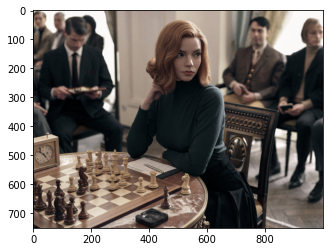

In [ ]:
print(caption)
image = Image.open(image_path)
plt.imshow(np.asarray(image))